In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report


# Load the dataset from a local CSV file
file_path = "dataset_small.csv"  # Adjust the path if necessary
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

# Check for missing values
print("Missing Values:\n", data.isnull().sum())

# Drop rows with missing values (if any)
data = data.dropna()

# Separate features (X) and target (y)
X = data.drop("phishing", axis=1)
y = data["phishing"]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



Missing Values:
 qty_dot_url             0
qty_hyphen_url          0
qty_underline_url       0
qty_slash_url           0
qty_questionmark_url    0
                       ..
qty_redirects           0
url_google_index        0
domain_google_index     0
url_shortened           0
phishing                0
Length: 112, dtype: int64


In [2]:
# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Training Set Size: {len(X_train)}")
print(f"Testing Set Size: {len(X_test)}")


Training Set Size: 41051
Testing Set Size: 17594


# Random Forest

In [3]:
# Create and train the Random Forest classifier
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

print("Model training complete.")


Model training complete.


In [4]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 95.74%
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      8428
           1       0.95      0.96      0.96      9166

    accuracy                           0.96     17594
   macro avg       0.96      0.96      0.96     17594
weighted avg       0.96      0.96      0.96     17594



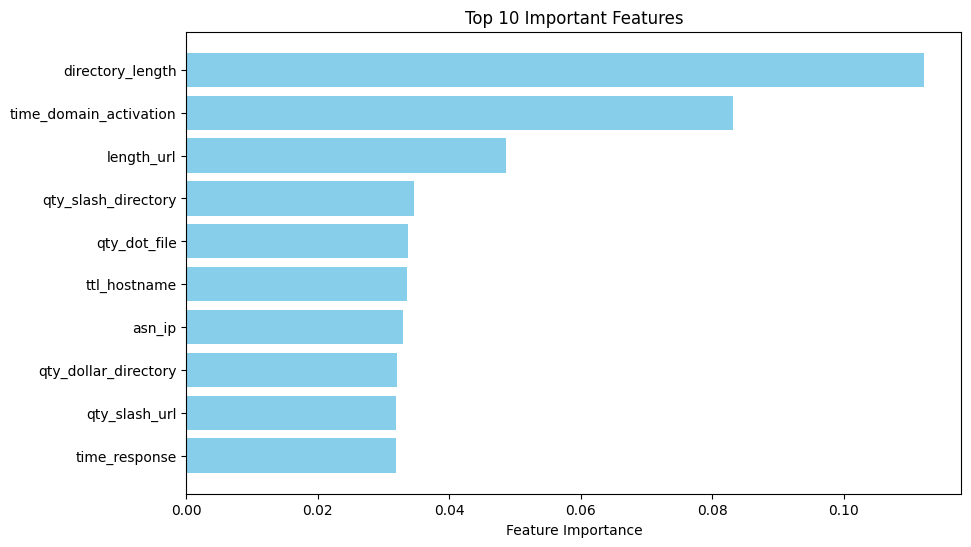

Top 10 Important Features:
                    Feature  Importance
57         directory_length    0.112241
100  time_domain_activation    0.083106
18               length_url    0.048585
43      qty_slash_directory    0.034692
58             qty_dot_file    0.033635
105            ttl_hostname    0.033595
99                   asn_ip    0.032951
55     qty_dollar_directory    0.031995
3             qty_slash_url    0.031902
97            time_response    0.031832


In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance and feature names
feature_importances = model.feature_importances_
features = X.columns

# Create a DataFrame for sorting and selection
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
})

# Sort by importance in descending order and take the top 10
top_features = importance_df.sort_values(by="Importance", ascending=False).head(10)

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()

# Print the top 10 features with their importance values
print("Top 10 Important Features:")
print(top_features)


In [6]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

class TabularTransformer(nn.Module):
    def __init__(self, input_dim, n_heads, n_layers, hidden_dim, output_dim):
        super(TabularTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # Positional encoding (initial dimensions are placeholders)
        self.positional_encoding = nn.Parameter(torch.randn(1, input_dim, hidden_dim))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim * 2,
            activation="relu",
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Classification head
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim),
        )

    def forward(self, x):
        # Dynamically adjust positional encoding to match batch size
        batch_size, seq_len = x.size()
        positional_encoding = self.positional_encoding[:, :seq_len, :].expand(batch_size, seq_len, -1)

        x = self.embedding(x).unsqueeze(1) + positional_encoding  # Add positional encoding
        x = self.transformer(x.permute(1, 0, 2)).permute(1, 0, 2)  # Transformer expects seq_length first
        x = x.mean(dim=1)  # Global Average Pooling
        x = self.fc(x)
        return x


# Model Parameters
input_dim = X_train.shape[1]
hidden_dim = 128
n_heads = 4
n_layers = 2
output_dim = 2  # Two classes: phishing or not

# Initialize model, loss function, and optimizer
model = TabularTransformer(input_dim, n_heads, n_layers, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
n_epochs = 20
batch_size = 64

for epoch in range(n_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i + batch_size]
        batch_y = y_train_tensor[i:i + batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_accuracy = accuracy_score(y_test, val_preds.numpy())
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Final Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_preds = torch.argmax(test_outputs, dim=1)
    print("\nClassification Report:")
    print(classification_report(y_test, test_preds.numpy()))


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.0848, Validation Accuracy: 0.9120
Epoch 2/20, Loss: 0.0512, Validation Accuracy: 0.9136
Epoch 3/20, Loss: 0.0486, Validation Accuracy: 0.9187
Epoch 4/20, Loss: 0.0282, Validation Accuracy: 0.9199
Epoch 5/20, Loss: 0.0356, Validation Accuracy: 0.9275
Epoch 6/20, Loss: 0.0366, Validation Accuracy: 0.9263
Epoch 7/20, Loss: 0.0376, Validation Accuracy: 0.9297
Epoch 8/20, Loss: 0.0178, Validation Accuracy: 0.9296
Epoch 9/20, Loss: 0.0093, Validation Accuracy: 0.9288
Epoch 10/20, Loss: 0.0202, Validation Accuracy: 0.9276
Epoch 11/20, Loss: 0.0167, Validation Accuracy: 0.9285
Epoch 12/20, Loss: 0.0167, Validation Accuracy: 0.9281
Epoch 13/20, Loss: 0.0213, Validation Accuracy: 0.9329
Epoch 14/20, Loss: 0.0163, Validation Accuracy: 0.9302
Epoch 15/20, Loss: 0.0159, Validation Accuracy: 0.9312
Epoch 16/20, Loss: 0.0135, Validation Accuracy: 0.9305
Epoch 17/20, Loss: 0.0116, Validation Accuracy: 0.9313
Epoch 18/20, Loss: 0.0112, Validation Accuracy: 0.9291
Epoch 19/20, Loss: 

# Logical Regression

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load-u
data = pd.read_csv('dataset_small.csv')
X = data.drop('phishing', axis=1)
y = data['phishing']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
modelL = LogisticRegression(random_state=42, max_iter=1000)
modelL.fit(X_train_scaled, y_train)

# Predictions
y_pred = modelL.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': abs(modelL.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5596
           1       0.89      0.91      0.90      6133

    accuracy                           0.90     11729
   macro avg       0.90      0.90      0.90     11729
weighted avg       0.90      0.90      0.90     11729


Top 10 Most Important Features:
                       feature  importance
93               params_length    2.266361
18                  length_url    2.011554
6                   qty_at_url    1.831467
95                  qty_params    1.487234
45         qty_equal_directory    1.394064
100     time_domain_activation    1.233297
57            directory_length    1.078727
83              qty_and_params    1.039293
48   qty_exclamation_directory    0.880464
94          tld_present_params    0.870936


# XG Boost

In [15]:
import xgboost as xgb

# Model
modelX = xgb.XGBClassifier(random_state=42)
modelX.fit(X_train, y_train)

# Make predictions on the test set
y_pred = modelX.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': modelX.feature_importances_})
feature_importance = feature_importance.sort_values('importance')
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5596
           1       0.96      0.96      0.96      6133

    accuracy                           0.96     11729
   macro avg       0.96      0.96      0.96     11729
weighted avg       0.96      0.96      0.96     11729


Top 10 Most Important Features:
                 feature  importance
55  qty_dollar_directory         0.0
29      qty_tilde_domain         0.0
30      qty_comma_domain         0.0
31       qty_plus_domain         0.0
32   qty_asterisk_domain         0.0
33    qty_hashtag_domain         0.0
34     qty_dollar_domain         0.0
35    qty_percent_domain         0.0
70         qty_plus_file         0.0
68        qty_tilde_file         0.0
